# Yolov4 Pytorch 1.7 for Edge Devices with Amazon SageMaker


Amazon SageMaker is a fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers. It also provides common machine learning algorithms that are optimized to run efficiently against extremely large data in a distributed environment. With native support for bring-your-own-algorithms and frameworks, SageMaker offers flexible distributed training options that adjust to your specific workflows.

SageMaker also offers capabilities to prepare models for deployment at the edge. [SageMaker Neo](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html) is a capability of Amazon SageMaker that enables machine learning models to train once and run anywhere in the cloud and at the edge and [Amazon SageMaker Edge Manager](https://docs.aws.amazon.com/sagemaker/latest/dg/edge.html) provides model management for edge devices so you can optimize, secure, monitor, and maintain machine learning models on fleets of edge devices such as smart cameras, robots, personal computers, and mobile devices.


In this notebook we'll train a [**Yolov4**](https://github.com/WongKinYiu/PyTorch_YOLOv4) model on Pytorch using Amazon SageMaker to draw bounding boxes around images and then, compile and package it so that it can be deployed on an edge device(in this case, a [Jetson Xavier](https://developer.nvidia.com/jetpack-sdk-441-archive)).



## 1) Pre-requisites

Let us start with setting up the pre-requisites for this notebook. First, we will sagemaker and other related libs and then set up the role and buckets and some variables. Note that, we are also specifying the size of the image and also the model size taken as Yolov4s where s stand for small. Check out the [github doc of yolov4](https://github.com/WongKinYiu/PyTorch_YOLOv4) to understand how model sizes differ.

In [69]:
import sagemaker
import numpy as np
import glob
import os
from sagemaker.pytorch.estimator import PyTorch

from matplotlib import pyplot as plt  # for image display
import matplotlib.patches as patches  # for image display
from PIL import Image as pil_image    # PIL is the Python Imaging Library for image display
import random                         # for image display
from pathlib import Path              # for image display

role = sagemaker.get_execution_role()
sagemaker_session=sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
img_size= 416 #reset to 416
model_type='tiny' # tiny or ''
model_name='yolov4'if model_type=='' else f"yolov4-{model_type}"

### 1.2) Image display constants

In [10]:
image_path = '/root/RI_Industry_Kit/cv-model/coco128/augmented_train/'
image_extension = '.jpg'
label_path = '/root/RI_Industry_Kit/cv-model/coco128/augmented_train_labels/'
label_extension = '.txt'

/root/RI_Industry_Kit/cv-model


### 1.3) Function to display image with all bounding boxes

In [65]:
def display_image_with_bounding_boxes (image, boxes):
    # function to display an image with its bounding boxes
    #
    # image is a Python Image Library image object holding image
    # boxes is a np.array holding bounding boxes
    #    in COCO format bounding box annotation
    #    [class, x_center, y_center, width, height]
    #    in dimensions as a fraction of the whole

    def add_bounding_box_to_image (axis, box, width, height):
        # function to add a single bounding box to an image
        #
        # axis is MatLibPlot axis object
        # box is np array holding dimensions for a single bounding box
        #    in COCO format bounding box annotation
        #    [class, x_center, y_center, width, height]
        #    in dimensions as a fraction of the whole
        # width is image width in pixels
        # height is image height in pixels
        
        # Create a Rectangle patch for the box
        
        if box[0] == 0:
            rect = patches.Rectangle(((box[1]-box[3]/2)*width, (box[2]-box[4]/2)*height),
                                 box[3]*width,
                                 box[4]*height,
                                 edgecolor='r',
                                 facecolor='none')
       
        elif box[0]==1: 
            rect = patches.Rectangle(((box[1]-box[3]/2)*width, (box[2]-box[4]/2)*height),
                                 box[3]*width,
                                 box[4]*height,
                                 edgecolor='y',
                                 facecolor='none')
        axis.add_patch(rect)
        
        
        
    # get image width & height
    width, height = image.size

    # Create the figure and axis
    fig, ax = plt.subplots()
    
    # set the image
    ax.imshow(np.array(image))    # convert image to np.array for use by MatLibPlot imshow
    
    # loop through boxes to add each bounding box to the image
    # get number of boxes
    number_of_boxes = boxes.shape[0]    # index 0 returns first dimension, index 1 returns second dimension, etc.
    for counter in range(number_of_boxes):    # loops from 0 to (number_of_boxes - 1)
        # get a single box from boxes
        box = boxes [counter]
        # add the bounding box to the image
        add_bounding_box_to_image (ax, box, width, height)
    
    # show the image with the bounding boxes
    plt.show()

## 2.4) Data engineering (inspection, preparation, and analysis)

#### 2.4.1) Label format

Lets look at the label format used for the dataset. It should follow the same standard as COCO.

If you need an example of the COCO format standard, a sample dataset is available [coco128](https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip). Use this code to download it.

```
if not os.path.exists('coco128'):
    !wget -q https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip
    !unzip -q coco128.zip && rm -f coco128.zip

In [46]:
print('BBoxes annotation')
print('class x_center y_center width height')
!head ./coco128/augmented_train_labels/0_1-18_thermal_cropped0_jpg.rf.5ed1cabcca1c7df81ed99c73c3113c61.txt

BBoxes annotation
class x_center y_center width height
0 0.625 0.35216346153846156 0.020432692307692308 0.018028846153846152
0 0.9194711538461539 0.4951923076923077 0.016826923076923076 0.016826923076923076
0 0.59375 0.35216346153846156 0.018028846153846152 0.020432692307692308
0 0.5625 0.35216346153846156 0.020432692307692308 0.016826923076923076
0 0.8052884615384616 0.4987980769230769 0.02403846153846154 0.021634615384615384
0 0.7668269230769231 0.4987980769230769 0.019230769230769232 0.018028846153846152
0 0.7295673076923077 0.5 0.020432692307692308 0.016826923076923076
0 0.6935096153846154 0.5 0.019230769230769232 0.018028846153846152
0 0.6526442307692307 0.5 0.019230769230769232 0.020432692307692308
0 0.8810096153846154 0.7199519230769231 0.016826923076923076 0.018028846153846152


#### 2.5) Randomly select five images and display them with there bounding boxes

/root/RI_Industry_Kit/cv-model/coco128/augmented_train_labels/
stem 4-11_thermal_cropped0_jpg.rf.752cccc3ceb51f7ffec9a66e2f0f3da1


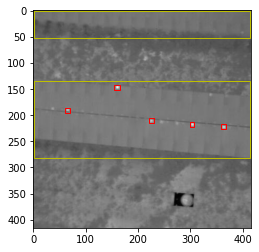

stem 2_3-0_thermal_cropped0_jpg.rf.24cad8f666e8e8b085715b914be1e481


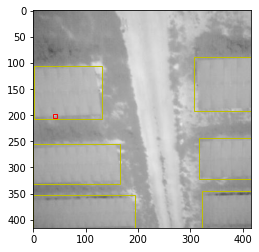

stem 2_3-1_thermal_cropped0_jpg.rf.25de1e21c98feb0b49d34d58669a3434


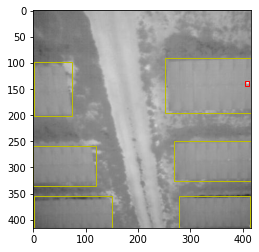

stem 4-3_thermal_cropped0_jpg.rf.c44a0d51f099c04c271973d2c4063793


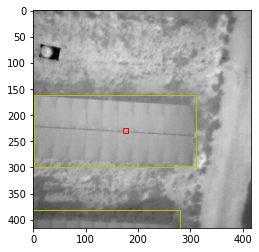

stem 4-12_thermal_cropped0_jpg.rf.d1886ddf51bf39f24434a2c2e978ef5f


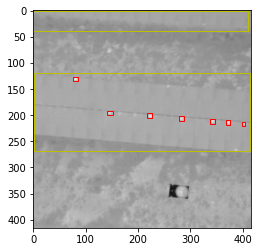

In [70]:
print(label_path)
for counter in range(5):
    # randomly get a filename with extension but without the path
    image_filename = random.choice(os.listdir(image_path))
    # get the stem of the filename
    file_stem = Path(image_filename).stem
    print("stem", file_stem)
    image_file = image_path + file_stem + image_extension    # create the full path to the image 
    label_file = label_path + file_stem + label_extension    # create the full path to the bounding box labels for the image
    
    if Path(label_path + file_stem + label_extension).stat().st_size > 0:    # ignore if the labels are empty
        # image as a np.array holding image
        image = pil_image.open(image_file)
        # boxes as a np.array holding bounding boxes
        boxes = np.genfromtxt(label_file, delimiter=' ')
        display_image_with_bounding_boxes (image, boxes)
    else:
        print("... has no bounding box labels")

## 2) Download a public implementation of Yolov4 for Pytorch (Author: Wong Kin Yiu)

Now, we will download the PyTorch implementation of Yolov4 from this [repository](https://github.com/WongKinYiu/PyTorch_YOLOv4) which is authored by Wong Kin Yiu. We will place it in a local directory `yolov4`

In [14]:
if not os.path.isdir('yolov4'):
    !git clone https://github.com/WongKinYiu/PyTorch_YOLOv4 yolov4
    !cd yolov4 && git checkout 3c42cbd1b0fa28ad19436d01e0e240404463ff80 && git apply ../mish.patch
    !echo 'tensorboard' > yolov4/requirements.txt

Cloning into 'yolov4'...
remote: Enumerating objects: 648, done.
remote: Total 648 (delta 0), reused 0 (delta 0), pack-reused 648
Receiving objects: 100% (648/648), 1.28 MiB | 3.92 MiB/s, done.
Resolving deltas: 100% (353/353), done.
Note: checking out '3c42cbd1b0fa28ad19436d01e0e240404463ff80'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 3c42cbd Update README.md


## 2.1) Train the model by preparing a Python script that will be the entrypoint of the training process

Now, we will create a training script to train the Yolov4 model. The training script will wrap the original training scripts and expose the parameters to SageMaker Estimator. The script accepts different arguments which will control the training process.

In [15]:
%%writefile yolov4/sagemaker_train.py
import sys
import subprocess
## We need to remove smdebug to avoid the Hook bug https://github.com/awslabs/sagemaker-debugger/issues/401
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "smdebug"])
import os
import yaml
import argparse
import torch
import shutil
import urllib
import numpy as np
from models.models import Darknet
from utils.parse_config import parse_model_cfg

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--num-classes', type=int, default=80, help='Number of classes')
    parser.add_argument('--img-size', type=int, default=640, help='Size of the image')
    parser.add_argument('--epochs', type=int, default=1, help='Number of epochs')
    parser.add_argument('--batch-size', type=int, default=16, help='Batch size')
    parser.add_argument('--adam', action='store_true', help='use torch.optim.Adam() optimizer')
    parser.add_argument('--pretrained', action='store_true', help='use pretrained model')
    
    parser.add_argument('--model-dir', type=str, default=os.environ["SM_MODEL_DIR"], help='Trained model dir')
    parser.add_argument('--train', type=str, default=os.environ["SM_CHANNEL_TRAIN"], help='Train path')
    parser.add_argument('--train-suffix', type=str, default='', help='Train path suffix')
    parser.add_argument('--validation', type=str, default=os.environ["SM_CHANNEL_VALIDATION"], help='Validation path')
    parser.add_argument('--validation-suffix', type=str, default='', help='Validation path suffix')
    
    parser.add_argument('--model-type', type=str, choices=['', 'tiny'], default="", help='Model type')
    
    # hyperparameters
    with open('data/hyp.scratch.yaml', 'r') as f:
        hyperparams = yaml.load(f, Loader=yaml.FullLoader)    
    for k,v in hyperparams.items():
        parser.add_argument(f"--{k.replace('_', '-')}", type=float, default=v)
    
    args,unknown = parser.parse_known_args()
    
    base_path=os.path.dirname(__file__)
    project_dir = os.environ["SM_OUTPUT_DATA_DIR"]

    # prepare the hyperparameters metadat
    with open(os.path.join(base_path,'data', 'hyp.custom.yaml'), 'w' ) as y:
        y.write(yaml.dump({h:vars(args)[h] for h in hyperparams.keys()}))

    # prepare the training data metadata
    with open(os.path.join(base_path,'data', 'custom.yaml'), 'w') as y:
        y.write(yaml.dump({            
            'names': [f'class_{i}' for i in range(args.num_classes)],
            'train': os.path.join(args.train, args.train_suffix),
            'val': os.path.join(args.validation, args.validation_suffix),
            'nc': args.num_classes
        }))

    model_name = "yolov4" if len(args.model_type) == 0 else f"yolov4-{args.model_type}"
    
    model_cfg_path = os.path.join(base_path, "cfg", f"{model_name}.cfg")
    model_params = parse_model_cfg(model_cfg_path)
    with open(model_cfg_path, 'w') as cfg:
        for p in model_params:
            if p['type'] == 'yolo':
                p['classes'] = args.num_classes
            elif p['type'] == 'convolutional' and p['filters'] == 255:
                p['filters'] = (args.num_classes + 5) * 3 # adjustment for the classes
            for k,v in p.items():
                if k=="type": cfg.write(f"[{v}]\n")
                else:
                    if type(v)==np.ndarray:
                        v = ','.join(str(i) for i in v.flatten().tolist())
                    elif type(v)==list:
                        v = ','.join(str(i) for i in v)
                    cfg.write(f"{k}={v}\n")
    
    # run the training script
    weights_file=''
    if args.pretrained:
        weights_file = f'weights/{model_name}.weights'
        urllib.request.urlretrieve(
            f'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/{model_name}.weights',
            weights_file
        )
        
    train_cmd = [
        sys.executable, os.path.join(base_path,'train.py'),
        "--data", "custom.yaml",
        "--hyp", "hyp.custom.yaml",
        "--cfg", f"cfg/{model_name}.cfg",
        "--img", str(args.img_size),
        "--batch", str(args.batch_size),
        "--epochs", str(args.epochs),
        "--logdir", project_dir,
        "--weights", weights_file
    ]
    if args.adam: train_cmd.append("--adam")
    subprocess.check_call(train_cmd)
        
    # tracing and saving the model
    inp = torch.rand(1, 3, args.img_size, args.img_size).cpu()
    ckpt = torch.load(os.path.join(project_dir, 'exp0', 'weights', 'best.pt'), map_location='cpu')
    model = Darknet(f"cfg/{model_name}.cfg").cpu()
    # do not invoke .eval(). we don't need the detection layer
    model.load_state_dict(ckpt['model'], strict=False)
    p = model(inp)
    model_trace = torch.jit.trace(model, inp)
    model_trace.save(os.path.join(args.model_dir, 'model.pth'))

Writing yolov4/sagemaker_train.py


### 2.1.2) Preparing the dataset

Here we'll download a sample dataset [coco128](https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip). We can also replace this step with any other dataset. 

Just take a look on the labels format and create your dataset scructure following the same standard (COCO).

In [16]:
import os
#if not os.path.exists('coco128'):
#    !wget -q https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip
#    !unzip -q coco128.zip && rm -f coco128.zip
print('BBoxes annotation')
print('class x_center y_center width height')
!head coco128/labels/train2017/2_3-1_thermal_cropped0.txt

BBoxes annotation
class x_center y_center width height
1 0.092686 0.640771 0.178457 0.247988
1 0.823887 0.310986 0.352227 0.184941
1 0.834795 0.075303 0.326777 0.150176
1 0.803408 0.657031 0.393184 0.250273
1 0.183643 0.077617 0.360371 0.148320
0 0.983154 0.667764 0.019668 0.025449
1 0.146367 0.288486 0.290430 0.181230


### 2.1.3) Upload the dataset to S3

Once the dataset has been downloaded locally, we'll upload the dataset to an S3 bucket created earlier. We are setting up the training and validation dataset s3 locations here.

In [17]:
prefix='data/coco128'
!rm -f coco128/labels/train2017.cache
train_path = sagemaker_session.upload_data('coco128', key_prefix=f'{prefix}/train')
val_path = sagemaker_session.upload_data('coco128', key_prefix=f'{prefix}/val')
print(train_path, val_path)

s3://sagemaker-eu-west-1-733414849973/data/coco128/train s3://sagemaker-eu-west-1-733414849973/data/coco128/val


In [18]:
!aws s3 rm --recursive s3://sagemaker-eu-west-1-733414849973/data/coco128/train/images/train2017/.ipynb_checkpoints
!aws s3 rm --recursive s3://sagemaker-eu-west-1-733414849973/data/coco128/train/labels/train2017/.ipynb_checkpoints
!aws s3 rm --recursive s3://sagemaker-eu-west-1-733414849973/data/coco128/val/images/train2017/.ipynb_checkpoints
!aws s3 rm --recursive s3://sagemaker-eu-west-1-733414849973/data/coco128/val/labels/train2017/.ipynb_checkpoints
!aws s3 ls --recursive s3://sagemaker-eu-west-1-733414849973/data/coco128/train
!aws s3 ls --recursive s3://sagemaker-eu-west-1-733414849973/data/coco128/val

2022-05-23 09:02:09      17343 data/coco128/train/augmented_train/.ipynb_checkpoints/0_1-10_thermal_cropped0_jpg.rf.0f36612bb29d471e8326689ad6a72780-checkpoint.jpg
2022-05-23 09:02:09      17294 data/coco128/train/augmented_train/.ipynb_checkpoints/0_1-10_thermal_cropped0_jpg.rf.582b148430bea9248fb4f4e04f5479fc-checkpoint.jpg
2022-05-23 10:32:06      17167 data/coco128/train/augmented_train/.ipynb_checkpoints/0_1-1_thermal_cropped0_jpg.rf.3b5750c2b009a82d7f66bf8d05447a0b-checkpoint.jpg
2022-05-23 09:02:09      12507 data/coco128/train/augmented_train/.ipynb_checkpoints/0_1-1_thermal_cropped0_jpg.rf.f09f2535c41caec2bd0b0b970ea4be8a-checkpoint.jpg
2022-05-23 10:32:04      17343 data/coco128/train/augmented_train/0_1-10_thermal_cropped0_jpg.rf.0f36612bb29d471e8326689ad6a72780.jpg
2022-05-23 10:32:01      17294 data/coco128/train/augmented_train/0_1-10_thermal_cropped0_jpg.rf.582b148430bea9248fb4f4e04f5479fc.jpg
2022-05-23 10:32:03      14077 data/coco128/train/augmented_train/0_1-10_therm

### 2.1.4) Prepare the SageMaker Estimator to train the model

Now it's time to create an Estimater and train the model with the training script created in earlier step. We are using Pytorch estimator and supplying other arguments in the estimator. Note that we are supplying the `source_dir` so that sagemaker can pick up the training script and other related files from there. Once the estimator is ready, we start the training using the `.fit()` method.

In [19]:
print(train_path, val_path)

s3://sagemaker-eu-west-1-733414849973/data/coco128/train s3://sagemaker-eu-west-1-733414849973/data/coco128/val


In [24]:
estimator = PyTorch(
    'sagemaker_train.py',
    source_dir='yolov4',
    framework_version='1.7',
    role=role,
    sagemaker_session=sagemaker_session, 
    instance_type='ml.p2.xlarge',    
    instance_count=1,
    py_version='py3', 
    hyperparameters={
        'epochs': 60, # at least 2 epochse
        'batch-size': 8,
        'lr0': 0.0001,
        
        'pretrained': True, # transfer learning
        'num-classes': 2,
        'img-size': img_size,
        'model-type': model_type,
        
        # the final path needs to point to the images dir
        'train-suffix': 'images/train2017',
        'validation-suffix': 'images/train2017'
    }
)

In [25]:
estimator.fit({'train': train_path, 'validation': val_path})

2022-05-23 10:37:40 Starting - Starting the training job...
2022-05-23 10:38:05 Starting - Preparing the instances for trainingProfilerReport-1653302259: InProgress
.........
2022-05-23 10:39:31 Downloading - Downloading input data......
2022-05-23 10:40:24 Training - Downloading the training image...........................
2022-05-23 10:45:05 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-23 10:45:03,750 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-23 10:45:03,781 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-23 10:45:03,789 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-23 10:45:04,425 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip instal

In [26]:
s3_uri=f'{estimator.output_path}{estimator.latest_training_job.name}/output/model.tar.gz'
print('trained model: ' + s3_uri )

trained model: s3://sagemaker-eu-west-1-733414849973/pytorch-training-2022-05-23-10-37-39-307/output/model.tar.gz


## 4) Compile your trained model for the edge device

Once the model has been traied, we need to compile the model using SageMaker Neo. This step is needed to compile the model for the specific hardware on which this model will be deployed. 

In this notebook, we will compile a model for [Jetson Xavier Jetpack 4.4.1](https://developer.nvidia.com/jetpack-sdk-441-archive). 

In case, you want to compile for a different hardware platform, just change the parameters bellow to adjust the target to your own edge device. Also, note, that if you dont have GPU available on the hardware device, then you can comment the `Accelerator` key:value in the `OutputConfig`.

The below cell also calls the `describe_compilation_job` API in a loop to wait for the compilation job to complete. In actual applications, it is advisable to setup a cloudwatch event which can notify OR execute the next steps once the compilation job is complete.

In [27]:
import time
import boto3
sm_client = boto3.client('sagemaker')
compilation_job_name = f'{model_name}-pytorch-{int(time.time()*1000)}'
sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': s3_uri,
        'DataInputConfig': f'{{"input": [1,3,{img_size},{img_size}]}}',
        'Framework': 'PYTORCH'
    },
    OutputConfig={
        'S3OutputLocation': f's3://{sagemaker_session.default_bucket()}/{model_name}-pytorch/optimized/',
        'TargetPlatform': { 
            'Os': 'LINUX', 
            'Arch': 'X86_64'#, # change this to X86_64 if you need
            #'Arch': 'ARM64', # change this to X86_64 if you need
            #'Accelerator': 'NVIDIA'  # comment this if you don't have an Nvidia GPU
        }#,
        # Comment or change the following line depending on your edge device
        # Jetson Xavier: sm_72; Jetson Nano: sm_53
        #'CompilerOptions': '{"trt-ver": "7.1.3", "cuda-ver": "10.2", "gpu-code": "sm_53"}' # Jetpack 4.4.1
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }
)
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(5)


Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
COMPLETED yolov4-tiny-pytorch-1653307274985


## 5) Download the compiled model

In [28]:
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights

In [29]:
# tracing and saving the model
#import torch
#inp = torch.rand(1, 3, 416, 416).cpu()
#ckpt = torch.load("yolov4-tiny.weights", map_location='cpu')
#model = Darknet(f"yolov4/cfg/{model_name}.cfg").cpu()
# do not invoke .eval(). we don't need the detection layer
#model.load_state_dict(ckpt['model'], strict=False)
#p = model(inp)
#model_trace = torch.jit.trace(model, inp)
#model_trace.save('model.pth')

In [30]:
output_model_path = f's3://{sagemaker_session.default_bucket()}/{model_name}-pytorch/optimized/model-LINUX_X86_64.tar.gz'

!aws s3 cp $output_model_path /tmp/model.tar.gz
!rm -rf model_object_detection && mkdir model_object_detection
!tar -xzvf /tmp/model.tar.gz -C model_object_detection

download: s3://sagemaker-eu-west-1-733414849973/yolov4-tiny-pytorch/optimized/model-LINUX_X86_64.tar.gz to ../../../tmp/model.tar.gz
compiled.so
compiled.params
dlr.h
libdlr.so
compiled_model.json
compiled.meta
manifest


## 6) Run the model locally

In [31]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


### 6.1) Load the model using the runtime DLR

In [32]:
!pip install dlr==1.8.0


 CALL HOME FEATURE ENABLED
                            

 You acknowledge and agree that DLR collects the following metrics to help improve its performance.                             
 By default, Amazon will collect and store the following information from your device:                             

 record_type: <enum, internal record status, such as model_loaded, model_>,                             
 arch: <string, platform architecture, eg 64bit>,                             
 osname: <string, platform os name, eg. Linux>,                             
 uuid: <string, one-way non-identifable hashed mac address, eg. 8fb35b79f7c7aa2f86afbcb231b1ba6e>,                             
 dist: <string, distribution of os, eg. Ubuntu 16.04 xenial>,                             
 machine: <string, retuns the machine type, eg. x86_64 or i386>,                             
 model: <string, one-way non-identifable hashed model name, eg. 36f613e00f707dbe53a64b1d9625ae7d>                         

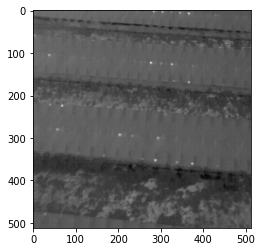

In [33]:
import utils
import dlr

# Read the image using OpenCV
img = cv2.imread('./coco128/images/train2017/2_3-15_thermal_cropped0.jpg')
# img = cv2.imread('./coco128/images/train2017/0_1-0_thermal_cropped0')
plt.imshow(img)


#img = np.random.rand(1,3,512,512).astype(np.float32)
#plt.imshow(img)

In [42]:
modelDLR = dlr.DLRModel('model_object_detection', 'cpu')

def predict(model, x):
    return model.run(x)

confidence_treshold=0.1
# Convert the image to the expected network input
x = utils.preprocess_img(img, img_size=416)
# Run the model and get the predictions
preds = predict(modelDLR, x)

# Convert the predictions into Detections(bounding boxes, scores and class ids)
detections = utils.detect(preds, 0.01, 0.2, True)

print('detection.')
print(detections)

# Iterate over the detections and do what you need to do
for top_left_corner,bottom_right_corner, conf, class_id in detections:
    if confidence_treshold < 0.1: continue
    print( f"bbox: {top_left_corner},{bottom_right_corner}, score: {conf}, class_id: {class_id}")

2022-05-23 17:34:02,756 INFO Found libdlr.so in model artifact. Using dlr from model_object_detection/libdlr.so


detection.
[[(-86, -28), (114, 65), 0.011206871829926968, 0.0], [(-86, -28), (114, 65), 0.02631297893822193, 1.0], [(-55, -27), (145, 63), 0.010780195705592632, 0.0], [(-55, -27), (145, 63), 0.025035355240106583, 1.0], [(-21, -25), (176, 62), 0.010713048279285431, 0.0], [(-21, -25), (176, 62), 0.024433515965938568, 1.0], [(10, -25), (208, 62), 0.010740340687334538, 0.0], [(10, -25), (208, 62), 0.024591954424977303, 1.0], [(42, -25), (240, 62), 0.010720659978687763, 0.0], [(42, -25), (240, 62), 0.024588556960225105, 1.0], [(74, -25), (272, 62), 0.010719740763306618, 0.0], [(74, -25), (272, 62), 0.02458658441901207, 1.0], [(106, -25), (304, 62), 0.010718824341893196, 0.0], [(106, -25), (304, 62), 0.02456519566476345, 1.0], [(138, -25), (336, 62), 0.010722346603870392, 0.0], [(138, -25), (336, 62), 0.024558693170547485, 1.0], [(170, -25), (368, 62), 0.010707165114581585, 0.0], [(170, -25), (368, 62), 0.024546794593334198, 1.0], [(202, -25), (400, 62), 0.010729428380727768, 0.0], [(202, -2

## 7) Create a SageMaker Edge Manager packaging job

Once the model has been compiled, it is time to create an edge manager packaging job. Packaging job take SageMaker Neo–compiled models and make any changes necessary to deploy the model with the inference engine, Edge Manager agent.

We need to provide the name used for the Neo compilation job, a name for the packaging job, a role ARN, a name for the model, a model version, and the Amazon S3 bucket URI for the output of the packaging job. Note that Edge Manager packaging job names are case-sensitive.


The below cell also calls the `describe_edge_packaging_job` API in a loop to wait for the packaging job to complete. In actual applications, it is advisable to setup a cloudwatch event which can notify OR execute the next steps once the compilation job is complete.

In [32]:
import time
model_version = '1.0'
edge_packaging_job_name=f'{model_name}-pytorch-{int(time.time()*1000)}'
resp = sm_client.create_edge_packaging_job(
    EdgePackagingJobName=edge_packaging_job_name,
    CompilationJobName=compilation_job_name,
    ModelName=model_name,
    ModelVersion=model_version,
    RoleArn=role,
    OutputConfig={
        'S3OutputLocation': f's3://{bucket_name}/{model_name}'
    }
)
while True:
    resp = sm_client.describe_edge_packaging_job(EdgePackagingJobName=edge_packaging_job_name)    
    if resp['EdgePackagingJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['EdgePackagingJobStatus'], compilation_job_name)
        print('package s3 location: ' + 's3://'+bucket_name+'/'+model_name)
        break
    time.sleep(5)

Running...
Running...
Running...
COMPLETED yolov4-tiny-pytorch-1652172077473
package s3 location: s3://sagemaker-eu-west-1-733414849973/yolov4-tiny


## 6) Pre processing + Post processing code
After compiling your model, it's time to prepare the application that will use it. In the image bellow you can see the operators that are used by the last layer **YOLOLayer**. When in evaluation mode, this layer applies some operations to merge the two outputs of the network and prepare the predictions for the **Non Maximum Suppression**. In training model, you just have the two raw outputs. 

Given we're using a pruned version (training mode) of the network, you need to apply some post processing code to your predictions.

<table style="border: 1px solid black; border-collapse: collapse;" border=3 cellpadding=0 cellspacing=0>
    <tr style="border: 1px solid black;">
        <td style="text-align: center; border-right: 1px solid;" align="center"><b>WITH DETECTION (evaluation mode)</b></td>
        <td style="text-align: center;" align="center"><b>NO DETECTION (training mode)</b></td>
    </tr>    
    <tr style="border: 1px solid black; border-right: 1px solid;">
        <td width="75%" style="border-right: 1px solid;">
            <img src="imgs/yolov4_detection.png"/>
        </td>
        <td>
            <img src="imgs/yolov4_no_detection.png"/>
        </td>
    </tr>
</table>

All the operations required by this process can be found in the script **[Utils](utils.py)**.
#### WARNING: run the next cell and copy the output to your **utils.py** before running the application. It is necessary to adjust the anchors and scores for the correct yolov4 version


Here it is an example of how to use the code:
```Python
import utils

### your code here
### def predict(model, x):...

confidence_treshold=0.1
# Read the image using OpenCV
img = cv2.imread('dog.jpg')
# Convert the image to the expected network input
x = utils.preprocess_img(img, img_size=416)
# Run the model and get the predictions
preds = model(x)
# Convert the predictions into Detections(bounding boxes, scores and class ids)
detections = utils.detect(preds, 0.25, 0.5, True)
# Iterate over the detections and do what you need to do
for top_left_corner,bottom_right_corner, conf, class_id in detections:
    if confidence_treshold < 0.1: continue
    print( f"bbox: {top_left_corner},{bottom_right_corner}, score: {conf}, class_id: {class_id}")
```

In [33]:
## This code parses the .cfg file of the version you're using and
## Prints the correct anchors/stride. Copy the output to the 'utils.py' file used by your application
import numpy as np

cfg_filename=f'yolov4/cfg/{model_name}.cfg'
yolo_layer=False
yolo_layers = []

for i in open(cfg_filename, 'r').readlines(): # read the .cfg file
    i = i.strip()
    if len(i) == 0 or i.startswith('#'): continue # ignore empty lines and comments
    elif i.startswith('[') and i.endswith(']'): # header
        if i.lower().replace(' ', '') == '[yolo]':
            yolo_layer = True # yolo layer
            yolo_layers.append({})
    elif yolo_layer: # properties of the layer
        k,v = [a.strip() for a in i.split('=')] # split line into key, value
        if k == 'anchors': # parse anchors
            anchors = np.array([int(j.strip()) for j in v.split(',')])
            yolo_layers[-1]['anchors'] = anchors.reshape((len(anchors)//2, 2))
        elif k == 'mask': # parse mask
            yolo_layers[-1]['mask'] = np.array([int(j.strip()) for j in v.split(',')])

stride = [8, 16, 32, 64, 128]  # P3, P4, P5, P6, P7 strides
if model_type == 'tiny':  # P5, P4, P3 strides
    stride = [32, 16, 8]

print("##### Copy the following lines to your util.py")
print(f"anchors = {[l['anchors'][l['mask']].tolist() for l in yolo_layers]}")
print(f"stride = {stride}")

##### Copy the following lines to your util.py
anchors = [[[81, 82], [135, 169], [344, 319]], [[23, 27], [37, 58], [81, 82]]]
stride = [32, 16, 8]


### Done !!

And we are done with all the steps needed to prepare the model for deploying to edge. The model package is avaialble in S3 and can be taken from there to deploy it to edge device. Now you need to move over to your edge device and download and setup edge manager agent(runtime), model and other related artifacts on the device. Please check out the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/edge.html) for detailed steps.

In [34]:
## 7) Setup Edge Manager Server
### 7.1) First you need to prepare and run a Cloudformation template to create the infrastructure required for running the Edge Manager
Run the next cell, click on the link it will create and don't forget to ack the capability in the Cloudformation screen

SyntaxError: invalid syntax (<ipython-input-34-96c5ceb21c4c>, line 3)

In [ ]:
import boto3
import sagemaker
from IPython import display

s3_client = boto3.client('s3')
sts_client = boto3.client('sts')

session = boto3.session.Session()
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.region_name
bucket_name = sagemaker_session.default_bucket()
account_id = sts_client.get_caller_identity()["Account"]

stack_name='experiments'
fleet_name=f'micro-device-fleet-{stack_name}'
device_name=f'device0-micro-device-fleet-{stack_name}'
policy_name=f'MicroDeviceFleetPolicy-{stack_name}'
iot_policy_name=f'SageMakerEdge-micro-device-fleet-{stack_name}'

template_url=f'https://s3.amazonaws.com/spock.cloud/ml-edge/micro-device-fleet.yml'
template_params={
    'stackName': stack_name,
    'param_BucketName': bucket_name,
    'param_SageMakerRoleArn': role
}
params = "&".join([f"{k}={v}" for k,v in template_params.items()])
cfn_quick_link=f"https://{region}.console.aws.amazon.com/cloudformation/home?region={region}#/stacks/create/review?templateURL={template_url}&{params}"

display.HTML(f'<a href="{cfn_quick_link}"> >>> Click <strong>here</strong> to launch the Cloudformation Stack, but don\'t forget to ack the following capability << </a> ')

In [ ]:
## 7.2) Install some dependencies

In [ ]:
!apt-get -y update && apt-get -y install build-essential procps
!pip install -U numpy sysv_ipc boto3 grpcio-tools grpcio protobuf sagemaker

In [ ]:
## 7.3) Download and prepare the SageMaker Edge Agent

In [ ]:
### 7.3.1) Download/unpack the agent for X86_64

In [ ]:
import boto3
import sagemaker
import os
import tarfile
import io
import stat

sm_client = boto3.client('sagemaker')

agent_version = '1.20210820.e20fa3a'
agent_pkg_bucket = 'sagemaker-edge-release-store-us-west-2-linux-x64'

if not os.path.isdir('agent'):
    s3_client = boto3.client('s3')

    # Download and install SageMaker Edge Manager
    agent_pkg_key = f'Releases/{agent_version}/{agent_version}.tgz'
    # get the agent package
    with io.BytesIO() as file:
        s3_client.download_fileobj(agent_pkg_bucket, agent_pkg_key, file)
        file.seek(0)
        # Extract the files
        tar = tarfile.open(fileobj=file)
        tar.extractall('agent')
        tar.close()
        # Adjust the permissions
        os.chmod('agent/bin/sagemaker_edge_agent_binary', stat.S_IXUSR|stat.S_IWUSR|stat.S_IXGRP|stat.S_IWGRP)
    
    # by using protoc, we can generate stubs (client api) for connecting to the agent and invoking its API
    if not os.path.isdir('app'): os.mkdir('app')
    !python3 -m grpc_tools.protoc --proto_path=agent/docs/api --python_out=app/ --grpc_python_out=app/ agent/docs/api/agent.proto

In [ ]:
### 7.3.2) Create the certificates if needed
These are IoT certificates, used by the agent to communicate with the cloud when needed: to send heartbeats and or capture data

In [ ]:
import urllib.request

cert_root_dir=os.path.join('agent', 'certificates', 'root')
cert_iot_dir=os.path.join('agent', 'certificates', 'iot')
if not os.path.isdir(cert_root_dir): os.makedirs(cert_root_dir)
if not os.path.isdir(cert_iot_dir): os.makedirs(cert_iot_dir)

# assume a different role (created by the CFN you executed at the beginning for IoT ops)
role_arn = f"arn:aws:iam::{account_id}:role/MicroDeviceFleetRole-{stack_name}"
temp_role = boto3.client('sts').assume_role(RoleArn=role_arn, RoleSessionName="MicroDeviceFleetSession2")
credentials = temp_role['Credentials']

iot_client = boto3.client(
    'iot',
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

if not os.path.isfile(os.path.join(cert_iot_dir, 'device0_key.pem')):
    print('Creating a new certificate')
    cert_meta = iot_client.create_keys_and_certificate(setAsActive=True)
    cert_arn = cert_meta['certificateArn']
    # attach the certificates to the policy and to the thing
    iot_client.attach_policy(policyName=policy_name, target=cert_arn)
    
    with open(os.path.join(cert_iot_dir, 'device0_cert.pem'), 'w') as c: c.write(cert_meta['certificatePem'])
    with open(os.path.join(cert_iot_dir, 'device0_key.pem'),  'w') as c: c.write(cert_meta['keyPair']['PrivateKey'])
    with open(os.path.join(cert_iot_dir, 'device0_pub.pem'),  'w') as c: c.write(cert_meta['keyPair']['PublicKey'])
    
    # get root certs
    urllib.request.urlretrieve('https://www.amazontrust.com/repository/AmazonRootCA1.pem', os.path.join(cert_root_dir, 'AmazonRootCA1.pem'))
    # this certificate validates the edge manage package
    s3_client.download_file(
        Bucket=agent_pkg_bucket, 
        Key=f'Certificates/{region}/{region}.pem', 
        Filename=os.path.join(cert_root_dir, f"{region}.pem")
    )        
    # adjust the permissions of the files
    os.chmod(os.path.join(cert_root_dir, 'AmazonRootCA1.pem'), stat.S_IRUSR|stat.S_IRGRP)
    os.chmod(os.path.join(cert_root_dir, f"{region}.pem"), stat.S_IRUSR|stat.S_IRGRP)

In [ ]:
### 7.3.3) Create the Agent config file

In [ ]:
import json
cred_host=iot_client.describe_endpoint(endpointType='iot:CredentialProvider')['endpointAddress']
agent_params = {
    "sagemaker_edge_core_device_name": device_name,
    "sagemaker_edge_core_device_fleet_name": fleet_name,
    "sagemaker_edge_core_capture_data_buffer_size": 30,
    "sagemaker_edge_core_capture_data_batch_size": 10,
    "sagemaker_edge_core_capture_data_push_period_seconds": 4,
    "sagemaker_edge_core_folder_prefix": "micro-device-fleet-data",
    "sagemaker_edge_core_region": region,
    "sagemaker_edge_core_root_certs_path": "./agent/certificates/root",
    "sagemaker_edge_provider_aws_ca_cert_file":"./agent/certificates/root/AmazonRootCA1.pem",
    "sagemaker_edge_provider_aws_cert_file": os.path.join(".", cert_iot_dir, 'device0_cert.pem'),
    "sagemaker_edge_provider_aws_cert_pk_file":os.path.join(".", cert_iot_dir, 'device0_key.pem'),
    "sagemaker_edge_provider_aws_iot_cred_endpoint": f"https://{cred_host}/role-aliases/{iot_policy_name}/credentials",
    "sagemaker_edge_provider_provider": "Aws",
    "sagemaker_edge_provider_provider_path" : os.path.abspath("./agent/lib/libprovider_aws.so"),
    "sagemaker_edge_provider_s3_bucket_name": bucket_name,
    "sagemaker_edge_core_capture_data_destination": "Cloud"
}
conf_dir = os.path.join('agent', 'conf')
conf_file_name='config_edge_device0.json'
if not os.path.isdir(conf_dir): os.makedirs(conf_dir)
with open(os.path.join(conf_dir, conf_file_name), 'w') as conf:
    conf_file = json.dumps(agent_params, indent=4)
    conf.write(conf_file)
    print(conf_file)

In [ ]:
## 8) Run the agent in background
The agent is a simple application that will run on your OS. Let's use subprocess to create a background process with the agent

In [ ]:
import subprocess
import time
channel_path='/tmp/agent_dev'
if os.path.exists(channel_path): os.remove(channel_path)
cmd = f'./agent/bin/sagemaker_edge_agent_binary -c agent/conf/{conf_file_name} -a {channel_path}'
print(cmd)
if not os.path.exists('agent/logs'): os.makedirs('agent/logs')
logs = open("agent/logs/agent0.log", "+w")
proc = subprocess.Popen(cmd.split(' '), stdout=logs)
time.sleep(2)
!ps aux --cols 300|grep sagemaker_edge_agent

In [ ]:
## 9) Test the model, using SageMaker Edge Agent

In [ ]:
import sys
sys.path.insert(1, 'app')
import numpy as np
import grpc

# Loading the stubs - agent python client
import agent_pb2 as agent
import agent_pb2_grpc as agent_grpc
import edge_agent_utils as edge

In [ ]:
# Connecting to the agent
channel = grpc.insecure_channel(f'unix://{channel_path}' )
client = agent_grpc.AgentStub(channel)

In [ ]:
model_alias='image-classification'

## Loading a model in the agent
edge.load_model(client, model_alias, model_path)

In [50]:
### Validate the model with a an image

In [ ]:
# quick and dirty parser for the labels
labels = {}
for l in open('labels.txt', 'r').read().splitlines():
    l = l.strip().replace('{', '').replace('}', '')
    l = l[:-1] if l.endswith(',') else l
    cls_id,label = [t.strip() for t in l.split(':')]
    labels[int(cls_id)] = label[1:-1] # remove the single quotes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
img_size=224
# load the image and make it squared if needed
img = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_BGR2RGB)
h,w,c = img.shape
if w!=h: # pad the image and make it square
    sqr_size = max(h,w)
    sqr_img = np.zeros((sqr_size, sqr_size, c), dtype=np.uint8)
    sqr_img[:h, :w],img = img,sqr_img
# resize the image to the expected size+transform it to pytorch/imagenet format
x = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
# normalize
x -= [0.485, 0.456, 0.406]
x /= [0.229, 0.224, 0.225]
x = x.transpose(2,0,1) # HWC --> CHW
c,h,w = x.shape
x = x.reshape(1,c,h,w) # CHW --> NCHW

In [ ]:
y = edge.predict(client, model_alias, x)
idx = np.argmax(y)
print(f"Class id: {idx}, Score: {y[0][idx]}, Label: {labels[idx]}")
plt.imshow(img)

In [ ]:
### Done, you can stop the agent now

In [ ]:
# stop the agent
proc.kill()